這裡開始已經假設你已經看過前面的所有基礎文件說明，因此多數註解會拿掉以維護版面乾淨

You Only Look Once，你只需要看一次，不需要先看框，再看類別，一次滿足檢測的所有需求。雖然已經有YOLOv4，但我們從YOLOv2重新來。

在下已有翻譯YOLOv2論文，也可以參閱[相關文件](在下已有翻譯LeNet-5論文，也可以參閱相關文件)，主要參考程式碼為[git_japap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0)

首先，我們要先取得資料集，會使用[Pascal VOC 2007的資料集](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html)，內有訓練、驗證、與測試三個子集。再請自行至上面連結內下載資料集即可。

解開tar之後，相關檔案會存在於資料夾VOCdevkit底下。不過就自己記得兩資料夾再解開，不然資料會混在一起。當然這個是看你介不介意，理論上是無所謂，因為文件內就有可以協助分離資料集的資料。

取得資料之後先認識一下資料

In [1]:
import os

In [2]:
path = '/tf/tf2/VOC2007/VOCdevkit/VOC2007'

In [3]:
os.listdir(path)

['JPEGImages',
 'ImageSets',
 'SegmentationObject',
 'SegmentationClass',
 'Annotations']

上面可以看的出來，資料集共有五個資料夾，其中的JPEGImages是比較直觀可以理解的，就是照片，我們拿Annotations裡面的一個文件來檢視

In [4]:
os.listdir(os.path.join(path, 'Annotations'))[0]

'004684.xml'

是個xml檔，因此我們就需要來parser這個xml看它裡面長什麼樣子，你可以直接parser這個xml，也可以轉dict，看個人，後面會以轉dict作業為主

In [5]:
import xml.etree.ElementTree as ET

In [6]:
tree = ET.ElementTree(file=os.path.join(path, 'Annotations', '005893.xml'))

In [7]:
for elem in tree.iter():
    print(elem.tag, elem.attrib, elem.text)

annotation {} 
	
folder {} VOC2007
filename {} 005893.jpg
source {} 
		
database {} The VOC2007 Database
annotation {} PASCAL VOC2007
image {} flickr
flickrid {} 321832155
owner {} 
		
flickrid {} kenny42952
name {} Kendrick Shackleford
size {} 
		
width {} 500
height {} 374
depth {} 3
segmented {} 0
object {} 
		
name {} train
pose {} Unspecified
truncated {} 1
difficult {} 0
bndbox {} 
			
xmin {} 1
ymin {} 84
xmax {} 479
ymax {} 182


把xml的結構print出來之後，有幾個比較重要的要先知道：
1. segmented: 是否用於分割
2. width: 照片的寬
3. height: 照片的高
4. depth: 照片的channel
5. name: 物件的類別
6. pose: 物件的姿勢
7. truncated: 照片是否被截斷
8. difficult: 是否難以辨識
9. xmin, ymin, xmax, ymax: bounding box左下、右上兩個點座標

如果照片上有多個物件，就會有多個object的tag，這部份可以再自行確認

下面我們拿這張照片出來驗證

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as img

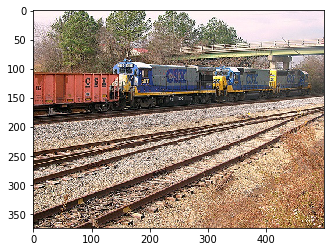

In [9]:
show_img = img.imread(os.path.join(path, 'JPEGImages', '005893.jpg'))
plt.imshow(show_img)
plt.show()

另一個需要注意的資料夾，就是ImageSets，這裡面Main的文件說明著你的資料集如何切分，其它的是用於其它的任務，後續有緣再來說明

In [10]:
os.listdir(os.path.join(path, 'ImageSets'))

['Layout', 'Main', 'Segmentation']

train、test、val三個資料集可以利用對應的三個文件來分割，因此上面才會說這資料混在一起也無所謂

In [11]:
with open(os.path.join(path, 'ImageSets', 'Main', 'train.txt')) as file:
    for f in file:
        print(f)
        break

000012



相關資料集說明至官方文件可以取得最清楚的說明，也提供一個不錯的簡中說明([arleyzhang](https://arleyzhang.github.io/articles/1dc20586/))給大家參考

現在，我們要開始處理資料集的資料整理問題，這部份其實有[現成的API](https://github.com/tensorflow/models/tree/master/research/object_detection)可以使用，但希望可以自己硬寫一發，這樣子可以更明白訓練所需的資料結構，這是模型架構之外另一個重要的議題

整個程式碼四處參考，列出參考來源：
1. [jmpap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0/blob/master/Yolo_V2_tf_2.ipynb)
2. [ying86615791](https://blog.csdn.net/ying86615791/article/details/102957513)

主要資料集的處理可以有兩種作法，一種是即時的取得資料，一種是將資料轉為tfrecord，首先我們來測試即時取得資料的方式。

我們知道，所有關於圖片的描述都在Annotations這資料夾內的xml裡面，因此我們要做的就是去解析這個xml，將這個xml弄成我們要的訓練資料格式

In [12]:
# 定義Annotations資料夾路徑
ann_folder = os.path.join(path, 'Annotations')

In [13]:
# 試著取得所有xml檔案
for ann in os.listdir(ann_folder):
    print(os.path.join(ann_folder, ann))
    break

/tf/tf2/VOC2007/VOCdevkit/VOC2007/Annotations/004684.xml


這邊我們可以先取單一檔案出來確認一下大致的檔案格式是怎麼樣，在那之前我們可以先試著將xml檔轉dict，看個人習慣，這可以利用xmltodict來處理，沒有的話就pip install xmltodict就可以了

我故意挑一個照片上有多個物件的xml檔來做範例，可以看的到object下有多個物件，後面我們在整理訓練資料的時候要注意到

In [14]:
import xmltodict
import numpy as np

In [15]:
f = open("/tf/tf2/VOC2007/VOCdevkit/VOC2007/Annotations/004686.xml", "r")
f_dict = xmltodict.parse(f.read(), force_list=True)['annotation']
f.close()

In [16]:
f_dict[0]

OrderedDict([('folder', ['VOC2007']),
             ('filename', ['004686.jpg']),
             ('source',
              [OrderedDict([('database', ['The VOC2007 Database']),
                            ('annotation', ['PASCAL VOC2007']),
                            ('image', ['flickr']),
                            ('flickrid', ['329940826'])])]),
             ('owner',
              [OrderedDict([('flickrid', ['Lothar Lenz']),
                            ('name', ['Lothar Lenz'])])]),
             ('size',
              [OrderedDict([('width', ['500']),
                            ('height', ['322']),
                            ('depth', ['3'])])]),
             ('segmented', ['0']),
             ('object',
              [OrderedDict([('name', ['horse']),
                            ('pose', ['Left']),
                            ('truncated', ['0']),
                            ('difficult', ['0']),
                            ('bndbox',
                             [OrderedDict([('x

我們會需要完整的影像資料夾名稱，因此先定義，後續結合使用

In [17]:
img_folder = os.path.join(path, 'JPEGImages')

然後我們要先設置一下label的對應，從上面的資料可以看的到，物件的名稱是以"文字"來描述，但我們無法直接使用文字，因此需要做轉換，這部份直接使用上面參考連結ying86615791的設置，可以看的到作者把很多的相同類型的東西做了大方向的分類

转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/ying86615791/java/article/details/102957513

In [18]:
VOC_NAME_LABEL_CLASS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

然後利用生成式直接產生對應表，這部份就不多說明

In [19]:
VOC_NAME_LABEL = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}
VOC_LABEL_NAME = {v[0]:key for key,v in VOC_NAME_LABEL_CLASS.items()}

現在我們要來試著取單筆的資料，因此迴圈內會加一個break來做為中斷點

In [71]:
# 是否處理難判斷的物件
# 要注意的是，如果後續你自己的資料集不打算有這個tag的話就不要設置處理
DIFFICULT = True 
# 記錄照片完全路徑
imgs_name = []
# 記錄照片的所有bound boxes
imgs_boxes = []
# 記錄一張照片多最多框有多少個
max_count = 0
# 取得資料筆數的flag，用於測試
i = 0
# 取得所有xml檔案
for ann in os.listdir(ann_folder):    
    # 用於記錄單張照片有幾個框
    bound_box_count = 0
    i += 1
    # 取讀檔案
    # print(f'now process: {os.path.join(ann_folder, ann)}')
    file = open(os.path.join(ann_folder, ann))
    dict_ann_data = xmltodict.parse(file.read(), force_list=True)['annotation'][0]
    file.close()
    # 開始處理資料格式
    # 這邊不做一些是否存在的判斷，直接假設你的資料都是符合資料格式
    # 記錄照片完整路徑
    imgs_name.append(os.path.join(img_folder, dict_ann_data["filename"][0]))
    # print(f'full path is: {os.path.join(img_folder, dict_ann_data["filename"][0])}')
    # 記錄照片的width、height
    w = int(dict_ann_data['size'][0]['width'][0])
    h = int(dict_ann_data['size'][0]['height'][0])
    # print(f'width: {w}, height: {h}')
    # 記錄照片中所有的物件資訊
    boxes = []
    
    # 判斷是否存在物件，有些照片可能只有背景
    # 不存在物件就直接解析下一個xml檔案
    if 'object' not in dict_ann_data:
        print('no object, pass!')
        continue       
    
    for obj in dict_ann_data['object']:
        bound_box_count += 1
        # 這邊加入一個是否處理難預測的照片，你也可以不要，看個人
        # 從上面的範例可以看的到，這邊檔案記錄的是字串0、1，因此需要轉型別         
        difficult = bool(int(obj['difficult'][0]))
        if difficult and DIFFICULT:
            continue
        # 記錄照片中物件的資訊
        # xmin、ymin、xmax、ymax、object label
        # 將座標做標準化是因為照片有大有小，而我們需要縮放至相同的大小
        # 才能一次批取資料，不然會報錯，因此這邊縮，取的時候放
        # 放的時候就依resize之後的比例做實際計算
        # 假設一個點的座標是在y=512，照片寬為512，那除之後就是1，放大至1024之後就是2
        box = np.zeros((5))
        box[0] = float(obj['bndbox'][0]['xmin'][0]) / w
        box[1] = float(obj['bndbox'][0]['ymin'][0]) / h
        box[2] = float(obj['bndbox'][0]['xmax'][0]) / w
        box[3] = float(obj['bndbox'][0]['ymax'][0]) / h
        box[4] = int(VOC_NAME_LABEL[obj['name'][0]])
        boxes.append(box)   
        # print(f'xmin: {box[0]}, ymin: {box[1]}, xmax: {box[2]}, ymax: {box[3]}, label: {box[4]}')
    
    # 記錄最大框，這稍後會用到
    if bound_box_count > max_count:
        max_count = bound_box_count
        # print(f'max_count change to: {max_count}')
            
    imgs_boxes.append(np.asarray(boxes))
    
    # 測試中，單純取10筆
    if i > 10:
        break

# 將照片的完整路徑list轉為numpy
imgs_name = np.array(imgs_name)
# 開一張大表要拿來寫入我們所取得的所有邊界框資訊
# 其維度為(照片量, 最大框數, 5)
# 5就是xmin, ymin, xmax, ymax, label
true_boxes = np.zeros((imgs_name.shape[0], max_count, 5))

for idx, boxes in enumerate(imgs_boxes):
    true_boxes[idx, :boxes.shape[0], :5] = boxes

直接看上面程式碼的最後一段可能會有點混亂，我們拆解來看

首先，imgs_boxes內有我們所照片的bound box的資訊

In [21]:
imgs_boxes

[array([[126.,  76., 464., 311.,   7.]]),
 array([[150.,   1., 394., 332.,   8.],
        [392., 142., 493., 333.,   5.]]),
 array([[  1.,  84., 479., 182.,  19.]]),
 array([[ 12.,  97., 332., 500.,   7.],
        [106.,  83., 297., 166.,   7.]]),
 array([[  2., 119., 443., 207.,  19.]]),
 array([[206., 226., 371., 478.,  16.],
        [187., 206., 228., 244.,  16.],
        [ 46., 210.,  84., 244.,  16.],
        [ 82., 348., 154., 429.,  16.]]),
 array([[114.,   2., 500., 349.,  10.]]),
 array([[ 40.,   4., 312., 408.,  15.],
        [ 99., 254., 220., 481.,  12.]]),
 array([[  2.,   3., 317., 373.,   8.]]),
 array([[196.,  93., 361., 207.,   7.]]),
 array([[129.,  84., 352., 316.,  15.]])]

記錄上一張照片最多框的是4個，因此開出來的表的每一筆資料都會有4個，沒有的就直接以0補掉

In [22]:
true_boxes[0]

array([[126.,  76., 464., 311.,   7.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.]])

到這邊，我們的資料整理也算是一個段落了，接著可以把它函數化，主要需要回傳的就是照片的完整路徑清單，以及每一張照片裡面的邊界框資訊，以我們的範例就是imgs_name與true_boxes

函數化之前就自己想一下，lable的mapping、最大邊界框、blablabla的東西，是要以全域變數來帶，還是要做為參數去帶，這個沒有一定，看個人需求就可以了

In [75]:
import os
import numpy as np
import xmltodict

def get_imgs_bounding_box(ann_folder, img_folder, label_mapping, is_difficult=False):
    """將Annotations的xml轉為訓練資料格式
    :param ann_folder: Annotations資料夾路徑
    :param img_folder: 照片資料夾路徑
    :param label_mapping: label的描述與索引關聯表
    :param is_difficult: 是否排除標記為困難的框
    
    returns
        imgs_name: 所有照片的完整路徑
        true_boxes: 所有照片的每一個邊界框的物件資訊
    """     
    # 記錄所有照片的完整路徑
    imgs_name = []
    # 記錄照片的所有bound boxes
    imgs_boxes = []
    # 記錄一張照片中最多框有多少個
    max_count = 0  
    
    # 取得所有xml檔案
    for ann in os.listdir(ann_folder):    
        # 記錄單張照片有幾個框
        bound_box_count = 0
        
        # 取讀檔案
        file = open(os.path.join(ann_folder, ann))
        dict_ann_data = xmltodict.parse(file.read(), force_list=True)['annotation'][0]
        file.close()
        
        # 開始處理資料格式
        # 這邊不做一些是否存在的判斷，直接假設你的資料都是符合資料格式
        # 記錄照片完整路徑
        imgs_name.append(os.path.join(img_folder, dict_ann_data["filename"][0]))        
        
        # 記錄照片的width、height
        w = int(dict_ann_data['size'][0]['width'][0])
        h = int(dict_ann_data['size'][0]['height'][0])        
        
        # 記錄照片中所有的物件資訊
        boxes = []

        # 判斷是否存在物件，有些照片可能只有背景
        # 不存在物件就直接解析下一個xml檔案
        if 'object' not in dict_ann_data:            
            continue       

        for obj in dict_ann_data['object']:
            bound_box_count += 1
            
            # 判斷是否處理難處理照片            
            difficult = bool(int(obj['difficult'][0]))
            if difficult and is_difficult:
                continue
                
            # 記錄照片中物件的資訊
            # xmin、ymin、xmax、ymax、object label
            # 座標點縮放
            box = np.zeros((5))
            box[0] = float(obj['bndbox'][0]['xmin'][0]) / w
            box[1] = float(obj['bndbox'][0]['ymin'][0]) / h
            box[2] = float(obj['bndbox'][0]['xmax'][0]) / w
            box[3] = float(obj['bndbox'][0]['ymax'][0]) / h
            box[4] = int(label_mapping[obj['name'][0]])
            boxes.append(box)               

        # 記錄一張照片中最大框的數量
        if bound_box_count > max_count:
            max_count = bound_box_count            
        
        imgs_boxes.append(np.asarray(boxes))

    # 將照片的完整路徑list轉為numpy
    imgs_name = np.array(imgs_name)

    # 開一張大表要拿來寫入我們所取得的所有邊界框資訊
    # 其維度為(照片量, 最大框數, 5)
    # 5就是xmin, ymin, xmax, ymax, label
    true_boxes = np.zeros((imgs_name.shape[0], max_count, 5))

    for idx, boxes in enumerate(imgs_boxes):
        true_boxes[idx, :boxes.shape[0], :5] = boxes

    return imgs_name, true_boxes

下面測試我們寫的函數是否正常執行

In [76]:
path = '/tf/tf2/VOC2007/VOCdevkit/VOC2007'
ann_folder = os.path.join(path, 'Annotations')
img_folder = os.path.join(path, 'JPEGImages')
label_mapping = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}

In [77]:
%%time
imgs_name, true_boxes = get_imgs_bounding_box(ann_folder, img_folder, label_mapping)

CPU times: user 3.59 s, sys: 44.3 ms, total: 3.63 s
Wall time: 3.63 s


In [78]:
imgs_name.shape, true_boxes.shape

((9963,), (9963, 42, 5))

取得資料清單之後，我們就可以利用[tensorflow的Dataset](https://github.com/shaoeChen/deeplearning/blob/master/tf2/MNIST_07_Keras(tf.data).ipynb)來產生一個generator

最重要的是，我們現在的資料集是照片的路徑，而不是tensor或numpy格式，因此我們需要處理載入照片的這個部份，這可以直接利用tensorflow的工具處理：
* [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file): return Tensor of type string.
* [tf.io.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_image): 解碼
* [tf.image.convert_image_dtype](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype): 轉換型別
* [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize): 尺寸轉換

In [27]:
import tensorflow as tf

In [83]:
def img2tensor(filename, true_boxes, h, w, channels=3):
    """將照片路徑轉為tensor"""    
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float32)   
    img = tf.image.resize(img, (h, w))
    return img, true_boxes

In [84]:
dataset = tf.data.Dataset.from_tensor_slices((imgs_name, true_boxes))
# 資料型別轉換，並縮放大小
dataset = dataset.map(lambda x, y: img2tensor(x, y, h=512, w=512))

In [85]:
# 資料打散
dataset = dataset.shuffle(3000, seed=10)
# 資料要重覆
dataset = dataset.repeat()
# 設置每批數量
# 這可以自己利用參數來設置
dataset = dataset.batch(1)
# 設置預取
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

可以測試列印照片出來喵喵看

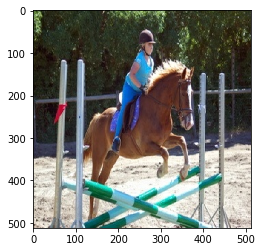

tf.Tensor(
[[[ 0.228125    0.22477064  0.74375     0.98165138 13.        ]
  [ 0.359375    0.08715596  0.559375    0.6559633  15.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0

In [86]:
for data in dataset.take(1):
    plt.imshow(data[0][0])
    plt.show()
    print(data[1])

現在一樣把產生dataset的部份寫成函數

In [87]:
def get_dataset(imgs_name, true_boxes, h, w, batch_size=5, shuffle=3000, seed=10):
    """生成tf.data.Dataset
    執行之前應該先從get_imgs_bounding_box取得照片路徑清單與實際框的資訊
    
    :params: imgs_name: 照片路徑清單
    :params: true_boxes: 照片內的邊界框資訊
    :params: h: 預計resize的照片高度
    :params: w: 預計resize的照片寬度
    :params: batch_size: 每次取批數量，預設為5
    :params: shuffle_num: 打散的數量，預設為3000
    :params: seed: 亂數種子，預設為10
    
    return
        dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((imgs_name, true_boxes))
    # 資料轉型別
    dataset = dataset.map(lambda x, y: img2tensor(x, y, h=h, w=w))
    # 資料打散
    dataset = dataset.shuffle(3000, seed=seed)
    # 資料要重覆
    dataset = dataset.repeat()
    # 設置每批數量
    # 這可以自己利用參數來設置
    dataset = dataset.batch(batch_size)
    # 設置預取
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [89]:
datasets = get_dataset(imgs_name, true_boxes, 512, 512, batch_size=5)

現在，讓我們利用matplotlib來畫出方框，子圖表的定義可以參考[蔽人拙作](https://github.com/shaoeChen/matplotlib/blob/master/Matplotlib_on_python_%E5%AD%90%E5%9C%96%E8%A1%A8%E8%88%87%E5%A4%9A%E5%9C%96%E8%A1%A8%E8%A8%AD%E7%BD%AE.ipynb)

In [90]:
import matplotlib.patches as patches

> <ipython-input-91-e0fff2ec4584>(3)<module>()
-> fig = plt.figure(figsize=(16, 9))
(Pdb) c
116.8 115.08256880733946 264.0 387.5229357798165 13.0
184.0 44.62385321100918 102.39999999999998 291.2293577981651 15.0


<Figure size 1152x648 with 0 Axes>

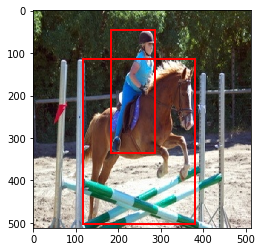

In [91]:
for data in datasets.take(1):    
    fig = plt.figure(figsize=(16, 9))
    img = data[0][0]    
    f, ax = plt.subplots(1, 1)
    ax.imshow(img)
    objects = data[1][0]
    # 一張照片上可能有多個物件，因此要迴圈處理    
    for idx in range(objects.shape[0]):
        obj = objects[idx]
        if obj[-1] == 0.:
            # 沒物件的時候就直接中斷迴圈
            break        
        # tensor to numpy
        box = obj.numpy()
        # 剛剛我們將座標點標準化，現在我們要將它還原為resize之後的照片大小
        x = box[0] * 512
        y = box[1] * 512
        w = (box[2] * 512) - (box[0] * 512)
        h = (box[3] * 512) - (box[1] * 512)
        label = box[4]
        
        # 畫方框
        rect = patches.Rectangle((x, y), 
                                 w, 
                                 h, 
                                 linewidth=2, 
                                 facecolor='none', 
                                 edgecolor='red')    
        print(x, y, w, h, label)
        ax.add_patch(rect)
        
plt.show()

一樣的，我們可以把這個繪圖出來確認的部份函數化

In [92]:
import matplotlib.patches as patches

def plot_dataset(datasets, h, w):
    """隨機取一張照片出來繪製
    
    請先利用get_dataset取得dataset
    
    :params: datasets: 從get_dataset取得的dataset
    :params: h: 預計resize的照片高度
    :params: w: 預計resize的照片寬度
    """
    for data in datasets.take(1):
        fig = plt.figure(figsize=(16, 9))
        img = data[0][0]    
        f, ax = plt.subplots(1, 1)
        ax.imshow(img)
        objects = data[1][0]
        # 一張照片上可能有多個物件，因此要迴圈處理    
        for idx in range(objects.shape[0]):
            obj = objects[idx]
            if obj[-1] == 0.:
                # 沒物件的時候就直接中斷迴圈
                break        
            # tensor to numpy
            box = obj.numpy()
            x = box[0] * w
            y = box[1] * h
            w = (box[2] * w) - (box[0] * w)
            h = (box[3] * h) - (box[1] * h)
            label = box[4]

            # 畫方框
            rect = patches.Rectangle((x, y), 
                                     w, 
                                     h, 
                                     linewidth=2, 
                                     facecolor='none', 
                                     edgecolor='red')    
            print(x, y, w, h, label)
            ax.add_patch(rect)
        
        plt.show()
        # 只需要一張，因此一次迭代就中斷
        break
    

測試一下效果

62.464 105.80522565320665 376.832 319.8479809976247 7.0


<Figure size 1152x648 with 0 Axes>

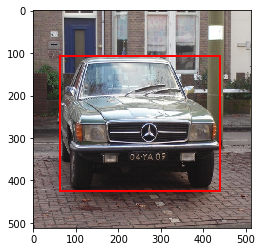

In [93]:
plot_dataset(datasets, 512, 512)

一定要注意到，照片大大小小，過程中我們需要特別注意的就是維度的問題。如果座標點沒有做這個標準化動作，那你一次只能取一張，如果取多張就會造成維度異常。到這邊我們已經有一個資料的生成器(雖然不是真的生成器)，還可以隨機繪製一張圖來確認我們的資料取得狀況。

在[參考連結jmpap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0/blob/master/Yolo_V2_tf_2.ipynb)中有另外再處理資料增強的部份，他所使用的是imgaug 這個套件，看起來不錯，有機會可以試一下。